In [2]:
%matplotlib inline
import os
import sys
import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
import pdb
import h5py
import subprocess
import datetime

import platform
if platform.system() == 'Darwin':
    # On a Mac: usetex ok
    mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=True)
elif platform.node().startswith("D"):
    # On hyak: usetex not ok, must change backend to 'agg'
    mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=False)
    plt.switch_backend('agg')
else:
    # On astro machine or other linux: usetex not ok
    plt.switch_backend('agg')
    mpl.rc('font', family='Times New Roman')
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=False)

In [4]:
import smart
import coronagraph as cg
import pandas as pd

In [6]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 200
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

In [8]:
lamhr, Ahr, fstar = cg.get_earth_reflect_spectrum()

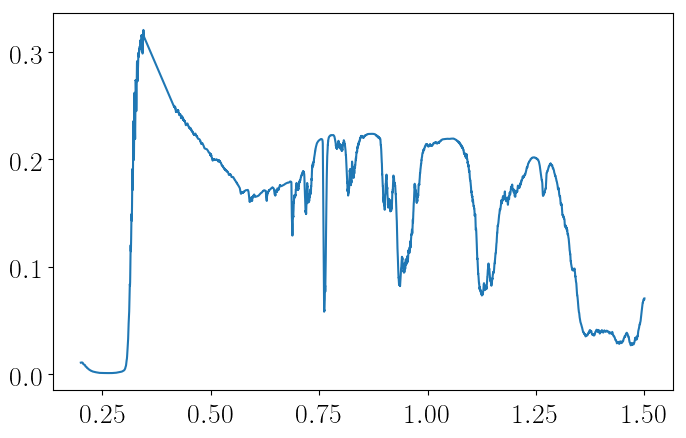

In [10]:
lammin = 0.2
lammax = 1.5
m = (lamhr > lammin) & (lamhr < lammax)

plt.plot(lamhr[m], Ahr[m])

In [152]:
telescope = cg.Telescope(lammin = 0.4, 
                         lammax = 1.4, 
                         R = 140, 
                         Tput = 0.1, 
                         D = 16.
                        )

planet = cg.Planet(d = 5.0, 
                   Rp = 1.0, 
                   a = 1.0, 
                   alpha = 90.0
                  )

star = cg.Star(Teff = 5780., 
               Rs = 1.0
              )

In [24]:
cn = cg.CoronagraphNoise(telescope = telescope, 
                         planet = planet, 
                         star = star, 
                         THERMAL=True)

In [25]:
cn.run_count_rates(Ahr, lamhr, fstar)

In [26]:
cn.make_fake_data(texp = 10)

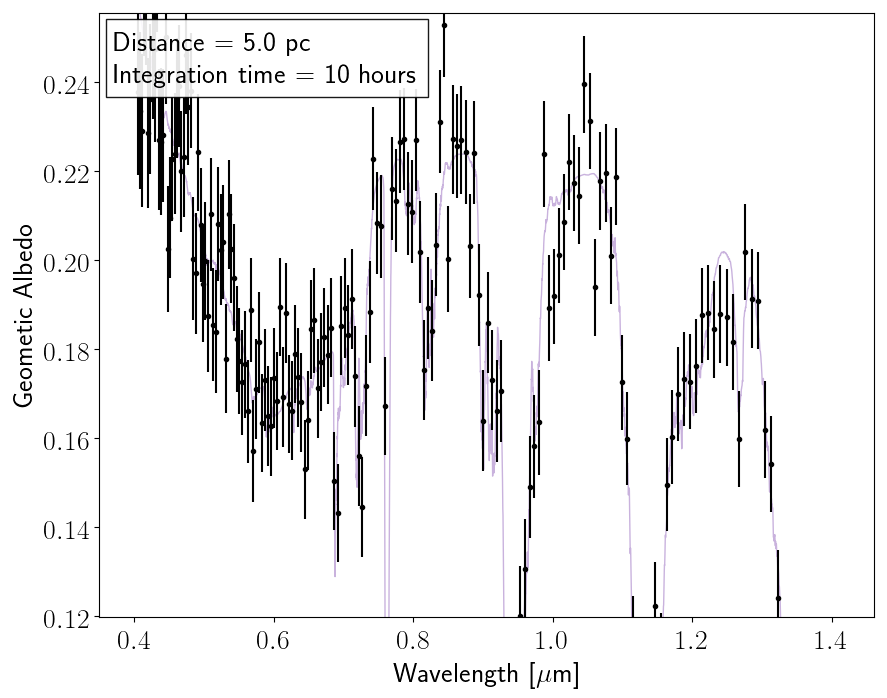

In [27]:
fig, ax = cn.plot_spectrum()

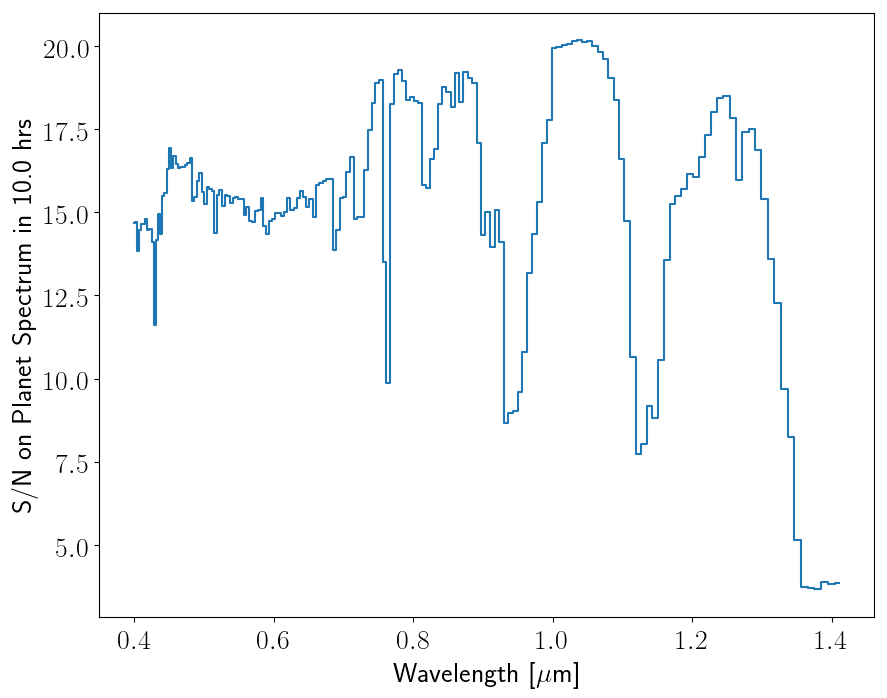

In [28]:
fig, ax = cn.plot_SNR()

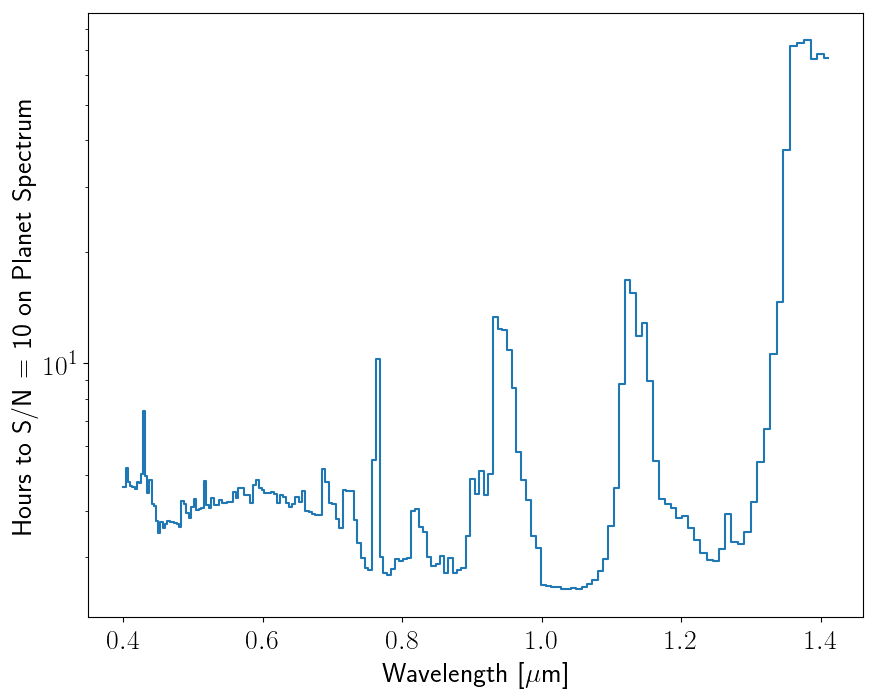

In [29]:
fig, ax = cn.plot_time_to_wantsnr()

In [139]:
# Set nominal SNR and exposure time values
wantSNR = 10.0
wantetime = 5.0
cn.make_fake_data(texp = wantetime)

2.21 hours to SNR = 10.00
SNR = 15.05 on band in a 5.00 hour exposure
SNR = 27.35 on bottom of band in a 5.00 hour exposure


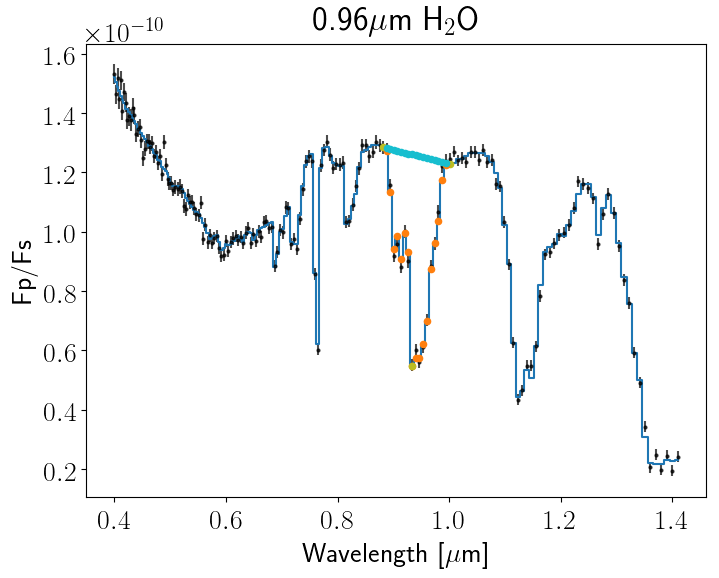

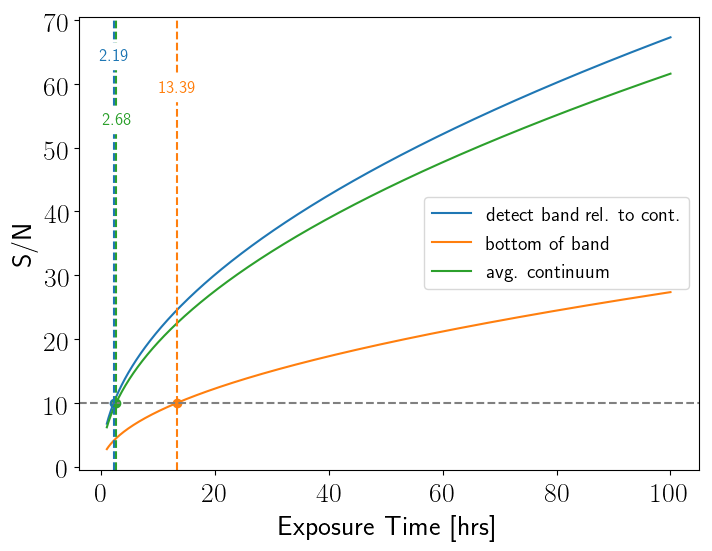

In [147]:
"""
# Specify band via array indices
icont = np.array([111, 128])
iband = np.arange(icont[0]+1, icont[1])
ibottom = 119
"""

# Specify band via wavelength
bandlims = [0.88, 1.0]
icont = np.array([np.argmin(np.fabs(cn.lam - bandlims[0])), np.argmin(np.fabs(cn.lam - bandlims[1]))])
iband = np.arange(icont[0]+1, icont[1])
ibottom = np.argmin(np.fabs(cn.Cratio - np.min(cn.Cratio[iband])))

# Construct noised spectrum plot
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(cn.lam, cn.Cratio, ls = "steps-mid")
ax.errorbar(cn.lam, cn.Cobs, yerr=cn.Csig, fmt = "ok", ms = 2.0, alpha = 0.7)
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Fp/Fs")
ax.set_title("0.96$\mu$m H$_2$O")

# Identify specific points in band
for i in icont:
    ax.scatter(cn.lam[i], cn.Cratio[i], s = 20.0, c = "C8", marker = "o", zorder = 100)
for i in iband:
    ax.scatter(cn.lam[i], cn.Cratio[i], s = 20.0, c = "C1", marker = "o", zorder = 100)
ax.scatter(cn.lam[ibottom], cn.Cratio[ibottom], s = 20.0, c = "C8", marker = "o", zorder = 100)

# Calculate the continuum planet photon counts and contrast ratio
ccont = cg.observe.interp_cont_over_band(cn.lam, cn.cp, icont, iband)
ccrat = cg.observe.interp_cont_over_band(cn.lam, cn.Cratio, icont, iband)

# Identify specific continuum points in band
for i, ic in enumerate(iband):
    ax.scatter(cn.lam[ic], ccrat[i], s = 20.0, c = "C9", marker = "o", zorder = 100)

# Calculate the exposure time to get desired SNR on band
etime = cg.observe.exptime_band(cn.cp, ccont, cn.cb, iband, SNR=wantSNR)
print("%.2f hours to SNR = %.2f" %(etime, wantSNR))

# Calculate the SNR on band in desired exposure time
eSNR = cg.observe.SNR_band(cn.cp, ccont, cn.cb, iband, itime=wantetime)
print("SNR = %.2f on band in a %.2f hour exposure" %(eSNR, wantetime))

print("SNR = %.2f on bottom of band in a %.2f hour exposure" %(cn.SNRt[ibottom], wantetime))

if True:
    
    # Calculate varies SNRs as a function of exposure time 
    Nt = 1000
    times = np.linspace(1.0, 100.0, Nt)
    band_snrs = np.zeros(len(times))
    bot_snrs = np.zeros(len(times))
    cont_snrs = np.zeros(len(times))
    for i, time in enumerate(times):
        cn.make_fake_data(texp = times[i])
        band_snrs[i] = cg.observe.SNR_band(cn.cp, ccont, cn.cb, iband, itime=times[i])
        bot_snrs[i] = cn.SNRt[ibottom]
        cont_snrs[i] = np.mean(cn.SNRt[icont])

    # Find nearest points to desired values
    #etime_band = cg.observe.exptime_band(cn.cp, ccont, cn.cb, iband, SNR=wantSNR)
    etime_band = times[np.argmin(np.fabs(band_snrs - wantSNR))]
    etime_bot = times[np.argmin(np.fabs(bot_snrs - wantSNR))]
    etime_cont = times[np.argmin(np.fabs(cont_snrs - wantSNR))]

    # Make plot of SNR vs exposure time
    fig, ax = plt.subplots(figsize = (8,6))
    ax.set_xlabel("Exposure Time [hrs]")
    ax.set_ylabel("S/N")
    ax.plot(times, band_snrs, label = "detect band rel. to cont.")
    ax.plot(times, bot_snrs, label = "bottom of band")
    ax.plot(times, cont_snrs, label = "avg. continuum")
    ax.scatter(etime_band, wantSNR, c="C0")
    ax.scatter(etime_bot, wantSNR, c="C1")
    ax.scatter(etime_cont, wantSNR, c="C2")
    ax.axhline(wantSNR, ls = "--", c = "grey")
    ax.axvline(etime_band, ls = "--", c = "C0")
    ax.axvline(etime_bot, ls = "--", c = "C1")
    ax.axvline(etime_cont, ls = "--", c = "C2")
    ylims = ax.get_ylim()
    ax.text(etime_band, ylims[1]-5, "%.2f" %etime_band, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C0")
    ax.text(etime_bot, ylims[1]-10, "%.2f" %etime_bot, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C1")
    ax.text(etime_cont, ylims[1]-15, "%.2f" %etime_cont, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C2")
    ax.legend(framealpha = 0.75, fontsize = 14)

16.48 hours to SNR = 10.00
SNR = 5.51 on band in a 5.00 hour exposure
SNR = 31.20 on bottom of band in a 5.00 hour exposure


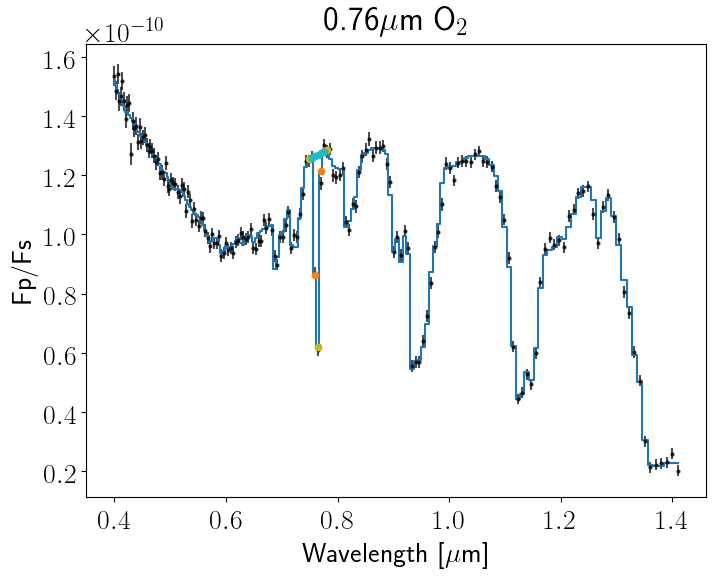

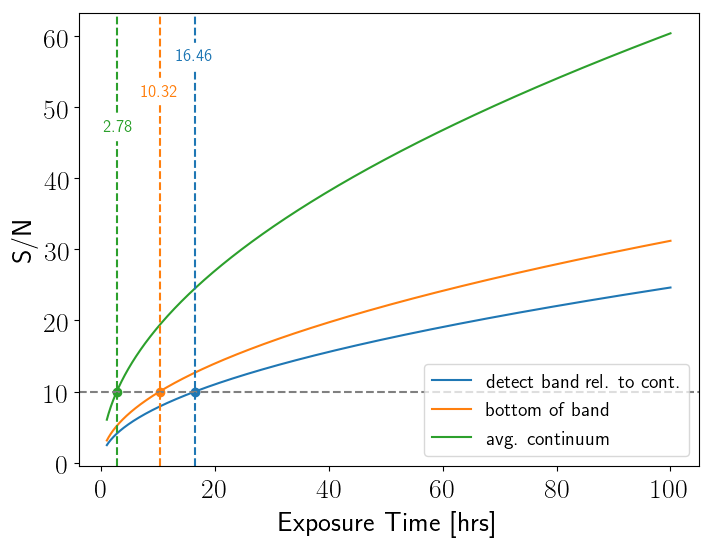

In [151]:
# Specify band via wavelength
bandlims = [0.75, 0.78]
icont = np.array([np.argmin(np.fabs(cn.lam - bandlims[0])), np.argmin(np.fabs(cn.lam - bandlims[1]))])
iband = np.arange(icont[0]+1, icont[1])
ibottom = np.argmin(np.fabs(cn.Cratio - np.min(cn.Cratio[iband])))

# Construct noised spectrum plot
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(cn.lam, cn.Cratio, ls = "steps-mid")
ax.errorbar(cn.lam, cn.Cobs, yerr=cn.Csig, fmt = "ok", ms = 2.0, alpha = 0.7)
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Fp/Fs")
ax.set_title("0.76$\mu$m O$_2$")

# Identify specific points in band
for i in icont:
    ax.scatter(cn.lam[i], cn.Cratio[i], s = 20.0, c = "C8", marker = "o", zorder = 100)
for i in iband:
    ax.scatter(cn.lam[i], cn.Cratio[i], s = 20.0, c = "C1", marker = "o", zorder = 100)
ax.scatter(cn.lam[ibottom], cn.Cratio[ibottom], s = 20.0, c = "C8", marker = "o", zorder = 100)

# Calculate the continuum planet photon counts and contrast ratio
ccont = cg.observe.interp_cont_over_band(cn.lam, cn.cp, icont, iband)
ccrat = cg.observe.interp_cont_over_band(cn.lam, cn.Cratio, icont, iband)

# Identify specific continuum points in band
for i, ic in enumerate(iband):
    ax.scatter(cn.lam[ic], ccrat[i], s = 20.0, c = "C9", marker = "o", zorder = 100)

# Calculate the exposure time to get desired SNR on band
etime = cg.observe.exptime_band(cn.cp, ccont, cn.cb, iband, SNR=wantSNR)
print("%.2f hours to SNR = %.2f" %(etime, wantSNR))

# Calculate the SNR on band in desired exposure time
eSNR = cg.observe.SNR_band(cn.cp, ccont, cn.cb, iband, itime=wantetime)
print("SNR = %.2f on band in a %.2f hour exposure" %(eSNR, wantetime))

print("SNR = %.2f on bottom of band in a %.2f hour exposure" %(cn.SNRt[ibottom], wantetime))

if True:
    
    # Calculate varies SNRs as a function of exposure time 
    Nt = 1000
    times = np.linspace(1.0, 100.0, Nt)
    band_snrs = np.zeros(len(times))
    bot_snrs = np.zeros(len(times))
    cont_snrs = np.zeros(len(times))
    for i, time in enumerate(times):
        cn.make_fake_data(texp = times[i])
        band_snrs[i] = cg.observe.SNR_band(cn.cp, ccont, cn.cb, iband, itime=times[i])
        bot_snrs[i] = cn.SNRt[ibottom]
        cont_snrs[i] = np.mean(cn.SNRt[icont])

    # Find nearest points to desired values
    #etime_band = cg.observe.exptime_band(cn.cp, ccont, cn.cb, iband, SNR=wantSNR)
    etime_band = times[np.argmin(np.fabs(band_snrs - wantSNR))]
    etime_bot = times[np.argmin(np.fabs(bot_snrs - wantSNR))]
    etime_cont = times[np.argmin(np.fabs(cont_snrs - wantSNR))]

    # Make plot of SNR vs exposure time
    fig, ax = plt.subplots(figsize = (8,6))
    ax.set_xlabel("Exposure Time [hrs]")
    ax.set_ylabel("S/N")
    ax.plot(times, band_snrs, label = "detect band rel. to cont.")
    ax.plot(times, bot_snrs, label = "bottom of band")
    ax.plot(times, cont_snrs, label = "avg. continuum")
    ax.scatter(etime_band, wantSNR, c="C0")
    ax.scatter(etime_bot, wantSNR, c="C1")
    ax.scatter(etime_cont, wantSNR, c="C2")
    ax.axhline(wantSNR, ls = "--", c = "grey")
    ax.axvline(etime_band, ls = "--", c = "C0")
    ax.axvline(etime_bot, ls = "--", c = "C1")
    ax.axvline(etime_cont, ls = "--", c = "C2")
    ylims = ax.get_ylim()
    ax.text(etime_band, ylims[1]-5, "%.2f" %etime_band, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C0")
    ax.text(etime_bot, ylims[1]-10, "%.2f" %etime_bot, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C1")
    ax.text(etime_cont, ylims[1]-15, "%.2f" %etime_cont, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C2")
    ax.legend(framealpha = 0.75, fontsize = 14)